---
title: "QuantLib, zero curves"
description: |
    A QuantLib têm diversos tipos de interpolação para estruturas a termo de taxas de juros.
    Vamos ver como utilizà-las neste post.
author:
  - name: Wilson Freitas
    url: {}
date: 2023-07-26
categories:
  - python
  - quantlib
  - brasa
---

[QuantLib]: https://www.quantlib.org/

No [post](../2023-07-19-quantlib/quantlib.ipynb) vimos a criação de uma curva de juros utilizando a classe
`ql.DiscountCurve` da QuantLib, que utiliza uma estrutura a termo dos fatores de desconto.
Aqui vamos ver como criar uma curva *zero* a partir das taxas de juros.
Nesta abordagem é possível criar curvas com outros tipos de interpolação, pois, na `DiscountCurve` a interpolação
utilizada é a linear nos logs dos fatores de desconto, que é equivalente a interpolação exponencial, muito
utilizada no mercado brasileiro, em particular para a curva de juros nominais.

[brasa]: https://github.com/wilsonfreitas/brasa

Vamos começar carregando os dados utilizando o projeto [brasa] e configurando a data de avaliação e o calendário na
QuantLib.

In [11]:
import os
os.environ["BRASA_DATA_PATH"] = "D:\\brasa"
import brasa
import pyarrow.compute as pc
from datetime import datetime
import QuantLib as ql

import pandas as pd
import matplotlib.ticker as mticker


curve = (brasa
         .get_dataset("b3-curves-di1")
         .filter(pc.field("refdate") == datetime(2023, 7, 14))
         .to_table()
         .to_pandas())

today = ql.Date().from_date(datetime(2023, 7, 14))
ql.Settings.instance().evaluationDate = today
calendar = ql.Brazil(ql.Brazil.Settlement)

### ZeroCurves



In [2]:
data = [(calendar.advance(today, d, ql.Days, ql.Following), r) for d, r in zip(curve["business_days"], curve["adjusted_tax"])]
data.insert(0, (today, data[0][1]))
dates, yields = zip(*data)

In [3]:
zc = ql.ZeroCurve(dates, yields, ql.Business252(calendar), calendar, ql.Linear(), ql.Compounded, ql.Annual)

In [4]:
zc.referenceDate()

Date(14,7,2023)

In [5]:
zc.nodes()[:5]

((Date(14,7,2023), 0.12795336431048324),
 (Date(17,7,2023), 0.12795336431046694),
 (Date(1,8,2023), 0.12794507014909243),
 (Date(1,9,2023), 0.1263153339122755),
 (Date(2,10,2023), 0.12534533483937893))

In [6]:
biz_days = calendar.businessDaysBetween(today, ql.Date(1,9,2023))
print(zc.zeroRate(biz_days/252, ql.Compounded))
print(zc.zeroRate(ql.Date(1,9,2023), ql.Business252(calendar), ql.Compounded))

13.463990 % Business/252(Brazil) Annual compounding
13.463990 % Business/252(Brazil) Annual compounding


In [7]:
llzc = ql.LogLinearZeroCurve(dates, yields, ql.Business252(calendar), calendar, ql.LogLinear(), ql.Compounded, ql.Annual)
czc = ql.CubicZeroCurve(dates, yields, ql.Business252(calendar), calendar, ql.Cubic(), ql.Compounded, ql.Annual)
nczc = ql.NaturalCubicZeroCurve(dates, yields, ql.Business252(calendar), calendar, ql.SplineCubic(), ql.Compounded, ql.Annual)
lczc = ql.LogCubicZeroCurve(dates, yields, ql.Business252(calendar), calendar, ql.DefaultLogCubic(), ql.Compounded, ql.Annual)
mczc = ql.MonotonicCubicZeroCurve(dates, yields, ql.Business252(calendar), calendar, ql.MonotonicCubic(), ql.Compounded, ql.Annual)

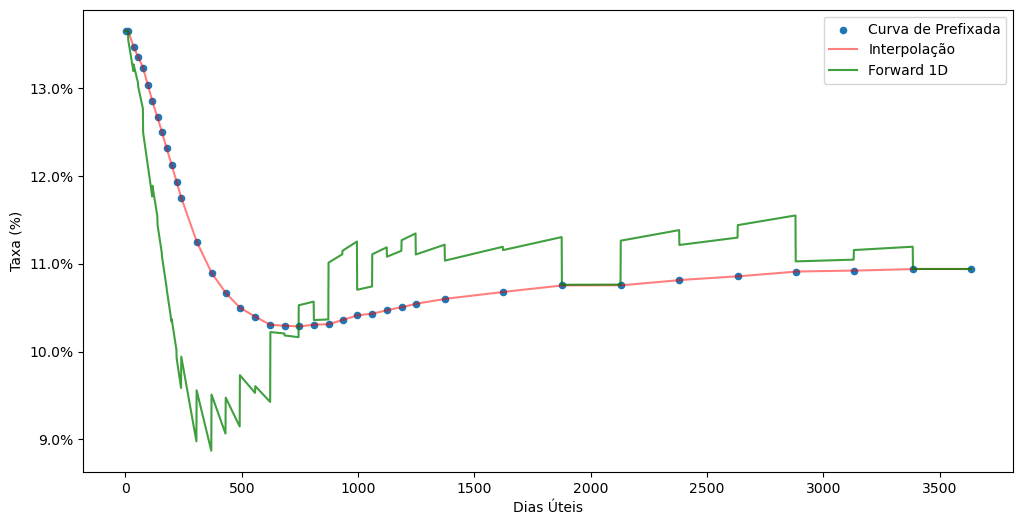

In [13]:
i_curve = pd.DataFrame({
    "days": list(range(1, curve["business_days"].max())),
    "rates": [zc.zeroRate(i/252, ql.Compounded).rate()
              for i in range(1, curve["business_days"].max())],
})

f_curve = pd.DataFrame({
    "days": list(range(1, curve["business_days"].max())),
    "rates": [zc.forwardRate(i/252, (i+1)/252, ql.Compounded).rate()
              for i in list(range(1, curve["business_days"].max()))],
})

ax = curve.plot.scatter(x="business_days", y="adjusted_tax", figsize=(12, 6),
                        label="Curva de Prefixada")
i_curve.plot(x="days", y="rates", c="red", alpha=0.5, ax=ax, label="Interpolação")
f_curve.plot(x="days", y="rates", c="green", alpha=0.75, ax=ax, label="Forward 1D")
ax.set_xlabel("Dias Úteis")
ax.set_ylabel("Taxa (%)")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1));

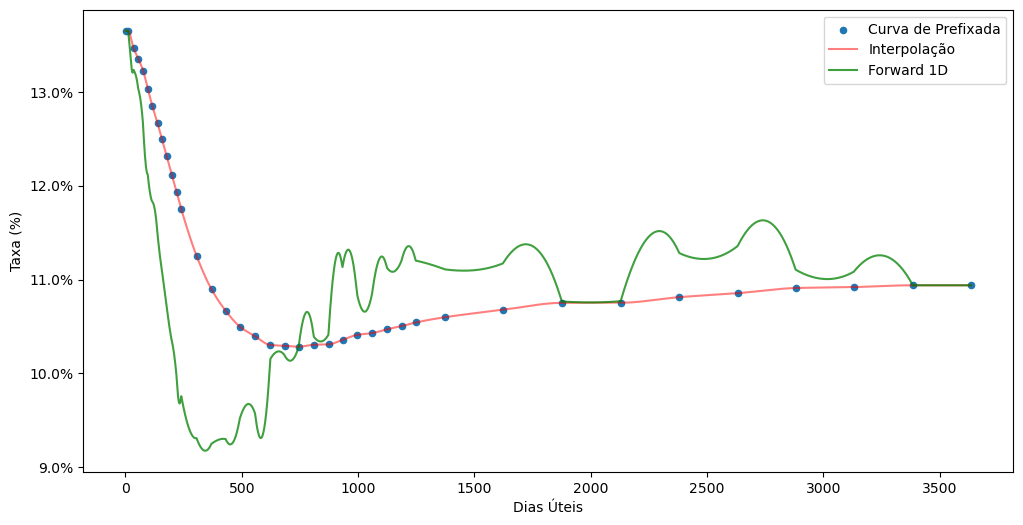

In [ ]:
i_curve = pd.DataFrame({
    "days": list(range(1, curve["business_days"].max())),
    "rates": [lczc.zeroRate(i/252, ql.Compounded).rate()
              for i in range(1, curve["business_days"].max())],
})

f_curve = pd.DataFrame({
    "days": list(range(1, curve["business_days"].max())),
    "rates": [lczc.forwardRate(i/252, (i+1)/252, ql.Compounded).rate()
              for i in list(range(1, curve["business_days"].max()))],
})

ax = curve.plot.scatter(x="business_days", y="adjusted_tax", figsize=(12, 6),
                        label="Curva de Prefixada")
i_curve.plot(x="days", y="rates", c="red", alpha=0.5, ax=ax, label="Interpolação")
f_curve.plot(x="days", y="rates", c="green", alpha=0.75, ax=ax, label="Forward 1D")
ax.set_xlabel("Dias Úteis")
ax.set_ylabel("Taxa (%)")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1));

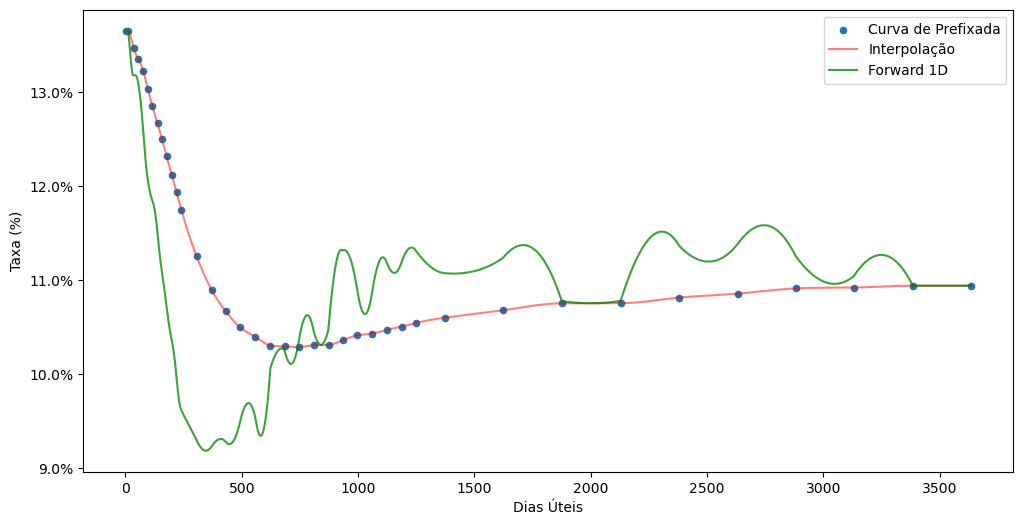

In [ ]:
i_curve = pd.DataFrame({
    "days": list(range(1, curve["business_days"].max())),
    "rates": [mczc.zeroRate(i/252, ql.Compounded).rate()
              for i in range(1, curve["business_days"].max())],
})

f_curve = pd.DataFrame({
    "days": list(range(1, curve["business_days"].max())),
    "rates": [mczc.forwardRate(i/252, (i+1)/252, ql.Compounded).rate()
              for i in list(range(1, curve["business_days"].max()))],
})

ax = curve.plot.scatter(x="business_days", y="adjusted_tax", figsize=(12, 6),
                        label="Curva de Prefixada")
i_curve.plot(x="days", y="rates", c="red", alpha=0.5, ax=ax, label="Interpolação")
f_curve.plot(x="days", y="rates", c="green", alpha=0.75, ax=ax, label="Forward 1D")
ax.set_xlabel("Dias Úteis")
ax.set_ylabel("Taxa (%)")
ax.yaxis.set_major_formatter(mticker.PercentFormatter(xmax=1.0, decimals=1));